In [16]:
import numpy as np
import scipy.signal
import scipy.optimize
import matplotlib.pyplot as plt
import control
%matplotlib inline

We start with a linear model of the system

In [9]:
nMV = 2
nCV = 2
G11 = scipy.signal.lti([-10.0], [20.0, 1]) # reflux to top , first digit indicates CV and second dight indicates MV
G21 = scipy.signal.lti([-5.0], [50.0,1]) # reflux to bottom 
G12 = scipy.signal.lti([3.0],[7.0,1]) # reboiler to top
G22 = scipy.signal.lti([2.0],[5.0,1]) # reboiler to bottom.
K = np.array([-10.0,3.0,-5.0,2.0]).reshape(2,2) # MVs are across the columns, CVs across the rows


In [10]:
M = 50  # Control horizon
P = 150  # Prediction horizon

In [11]:
ABSU = np.array([50,2000]).reshape(-1,1)
U= np.ones(nMV).reshape(-1,1) # initial move 
ABSY0 = np.array([80,100]).reshape(-1,1) # initial value of top purity and bottom temp
ABSYSP = np.array([82,104]).reshape(-1,1) # desired target entered by the user. 
YSP = (ABSYSP -ABSY0).reshape(-1,1) # desired deviation 


In [12]:
Q= np.array([1,2])#.reshape(-1,1) # CV Weight 
R= np.array([0.1,0.1])#.reshape(-1,1) # MV Weight 

### steady state solver
- this since this control problem is feasible , it can be solved algebraically. There is no need for steady state optimization.

In [13]:
#try linear algebra to solve the steady state 
from scipy import linalg
USS = linalg.solve(K,YSP)
YSS = YSP
USS

array([[ 1.6],
       [ 6. ]])

### move plan optimization (Dynamic optimization)

In [21]:
#u = USS*np.ones(M) # u is an array of length  M ( control horizon ) , that holds the MV move plan , initially set to the steady state move
u = np.zeros((nMV,M))
yref = np.tile(YSS,P) # reference trajectory
yref


array([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

In [14]:
# this function repeats holds the last move of the controller steady , from the control horizaon to prediction horizon 
# as after control horizon, the MV will not move. 
def extend(uf):
    uf1 = uf.reshape(nMV,-1) # this step is required because , scipy optimize can return only  flattened arrays, which should be
    # "folded back" to proper shape.
    
    
    ext = np.tile(uf1[:,[-1]],(P-M))
    return np.hstack((uf1,ext))


In [23]:

A = np.diag([-0.05,-0.02,-0.2,-0.1429])
A.shape[1]



4

In [24]:
B = np.array([[0.5,0],[0.25,0],[0,0.5],[0,0.5]])
C = np.array([[-1,0,0.8,0],[0,-0.4,0,0.8571]])
x = np.zeros((A.shape[1],1))
C.shape

(2, 4)

In [56]:
#the predictions should be based on the delta MVs  
def prediction(u):
    ts = np.linspace(0, P, P)
    dt = ts[1]
    x = np.zeros((A.shape[1],1)) # state vector
    ys = np.zeros((nCV,P)) # prediction matrix
    dxdt = np.zeros((A.shape[1],1)) # alwasn initialize the arrays. 
    
    deltau = 
    
    for i,t in enumerate(ts):
        dxdt = A.dot(x)+B.dot((u[:,[i]]))
        x = x + dxdt*dt
        y = C.dot(x) # output vector
        
        ys[:,i] = y[:,0] # this assigns the ith column of a numpy array to another vect
    #print(ys)
    return ys


note: the np.diff function starts differencing from second element ( to the first element ) . however, we need to include the first element of the input array for penalization . hence the vstack functino is used to add the first column for penalization

### unconstrained optimization

In [54]:
def objective(u):
    #ypred = np.empty((nCV,P)) # can be deleted , i think,
    ypred = prediction(extend(u))
    
    upro = u.reshape(nMV,-1)
        
    #YC = np.vstack((YC1,YC2)) # note the one argument given within double brackets.
    obj = np.sum((np.dot(np.square(ypred-yref).T,Q))) + np.sum(np.dot(np.square(upro.T),R))
    #obj = np.sum((Q*(ypred-yref))**2)+np.sum((np.diff(upro))**2*R)
    #print(obj)
    return obj

In [57]:
uopt = scipy.optimize.minimize(objective, u).x
uoptpro = uopt.reshape(nMV,-1)


In [64]:
u

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [62]:
np.diff(uoptpro).shape

(2, 49)

In [58]:
uoptpro[:,[0]]

array([[ 1.43355284],
       [ 7.73990559]])

In [29]:
print(sum(uoptpro[0]),sum(uoptpro[1]))

6.26688685132 79.0840968489


In [30]:
ypred = prediction(extend(uopt))

Resample the discrete output to continuous time

Plot the move plan and the output. Notice that we are getting exactly the output we want at the sampling times.

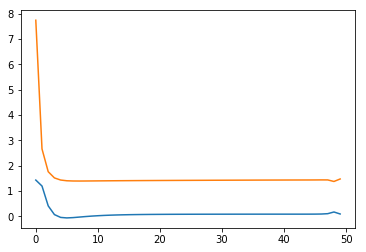

In [52]:
plt.plot(uoptpro[0])
plt.plot(uoptpro[1])

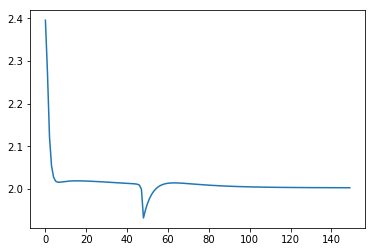

In [32]:
plt.plot(ypred[0])

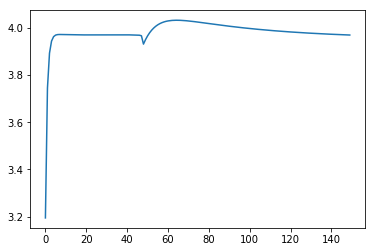

In [33]:
plt.plot(ypred[1])

In [34]:
uoptpro

array([[  1.43355284e+00,   1.19752404e+00,   4.14708426e-01,
          7.13561075e-02,  -4.03190588e-02,  -6.00477950e-02,
         -4.78781702e-02,  -2.71959461e-02,  -6.47203080e-03,
          1.16347322e-02,   2.66299291e-02,   3.87563473e-02,
          4.84550765e-02,   5.61721898e-02,   6.23027017e-02,
          6.71729772e-02,   7.10491960e-02,   7.41421011e-02,
          7.66192523e-02,   7.86105747e-02,   8.02190155e-02,
          8.15256448e-02,   8.25933621e-02,   8.34737986e-02,
          8.42060396e-02,   8.48203479e-02,   8.53431414e-02,
          8.57912674e-02,   8.61809579e-02,   8.65218483e-02,
          8.68245534e-02,   8.70935347e-02,   8.73342226e-02,
          8.75504501e-02,   8.77435773e-02,   8.79138167e-02,
          8.80596140e-02,   8.81783595e-02,   8.82680983e-02,
          8.83265391e-02,   8.83515846e-02,   8.83471654e-02,
          8.83367166e-02,   8.83958519e-02,   8.87399755e-02,
          8.99569680e-02,   9.38039697e-02,   1.07262808e-01,
        

we notice that  during dynamic optimization , the  "u" calculated is different than the steady state optimization .
it is because , the steady state targets of u are not enforced in dynamic optimization. In order to enforce this , we should include this as a equality constraint in the scipy optimization function.  

In [35]:
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x[0])-1.6}, {'type':'eq','fun': lambda x:  np.sum(x[1]) - 6})
    
    

### things to do
1. develop a steadystate solver that calculates the steady state targets
inputs:
    . model
    . initial conditions of MV 
    . initial conditions of CVs
    . CV targets. 
    . CV priorities. 
    . CV Weights. 
  ouputs
  . CV targets
  . MV Targets
 2. devleop constrained optimizer.  ( max move constraints, vavle position constraints)
 3. estimate state using kalman 
 
 
 Flow chart 
 1. calculate the set of optimal moves 
 2. implement the first move
 3. implement the state estimator 
 4. update the predictions, calculate the new set of moves
 5.

In [36]:
uss = np.tile(USS,M)
np.sum((uss-u)**2)

1928.0

In [46]:
def objectivetarget(u):
    #ypred = np.empty((nCV,P)) # can be deleted , i think,
    ypred = prediction(extend(u))
    
    upro = u.reshape(nMV,-1)
        
    #YC = np.vstack((YC1,YC2)) # note the one argument given within double brackets.
    obj = np.sum((np.dot(np.square(ypred-yref).T,Q))) + np.sum(np.dot(np.square(upro.T),R))
    #obj = np.sum((Q*(ypred-yref))**2)+np.sum((np.square(upro))*R)
    #print(obj)
    return obj

In [47]:
uopt = scipy.optimize.minimize(objectivetarget, u).x
#uoptpro = uopt.reshape(nMV,-1)

In [48]:
uoptpro = uopt.reshape(nMV,-1)

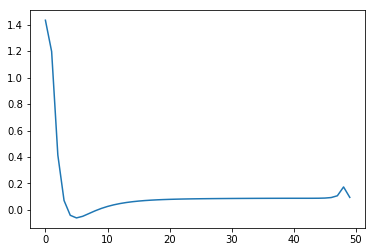

In [49]:
plt.plot(uoptpro[0])

In [51]:
uoptpro

array([[  1.43355284e+00,   1.19752404e+00,   4.14708426e-01,
          7.13561075e-02,  -4.03190588e-02,  -6.00477950e-02,
         -4.78781702e-02,  -2.71959461e-02,  -6.47203080e-03,
          1.16347322e-02,   2.66299291e-02,   3.87563473e-02,
          4.84550765e-02,   5.61721898e-02,   6.23027017e-02,
          6.71729772e-02,   7.10491960e-02,   7.41421011e-02,
          7.66192523e-02,   7.86105747e-02,   8.02190155e-02,
          8.15256448e-02,   8.25933621e-02,   8.34737986e-02,
          8.42060396e-02,   8.48203479e-02,   8.53431414e-02,
          8.57912674e-02,   8.61809579e-02,   8.65218483e-02,
          8.68245534e-02,   8.70935347e-02,   8.73342226e-02,
          8.75504501e-02,   8.77435773e-02,   8.79138167e-02,
          8.80596140e-02,   8.81783595e-02,   8.82680983e-02,
          8.83265391e-02,   8.83515846e-02,   8.83471654e-02,
          8.83367166e-02,   8.83958519e-02,   8.87399755e-02,
          8.99569680e-02,   9.38039697e-02,   1.07262808e-01,
        

In [50]:
np.sum(uoptpro[1])

79.084096848942224

In [ ]:
ypred1 = prediction(extend(uoptpro))

In [ ]:
plt.plot(ypred1[0])

In [ ]:
plt.plot(ypred1[1])

It looks like , still the dynamic optimization for the inputs U still does not match with the steady state optimization prediction 

In [ ]:
u1 = np.ones((2,P))

In [ ]:
u1[1,:]=0

In [ ]:
u1

In [ ]:
yp = prediction(extend(u1))

In [ ]:
plt.plot(yp[0])
plt.plot(yp[1])

In [44]:
uoptqp = scipy.optimize.minimize(objectivetarget,u, method='SLSQP').x

ValueError: Objective function must return a scalar

In [ ]:
uoptproqp = uopt.reshape(nMV,-1)

In [ ]:
uoptproqp

In [ ]:
uss